# Data Visualization and Statistics
Examines the raw training and test data, as well as new data pulled from external sources

In [2]:
# All imports
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import utils
import matplotlib.pyplot as plt

# Raw training and test data

In [3]:
# Load raw data
raw_train_df = pd.read_csv(utils.RAW_TRAIN_PATH, dtype={"accession": str, "score": float})
raw_test_df = pd.read_csv(utils.RAW_TEST_PATH, dtype={"accession": str, "score": float})

In [4]:
# load top 10 most populated scoresets
K = 10
top_sets = raw_train_df["scoreset"].value_counts().head(K).index

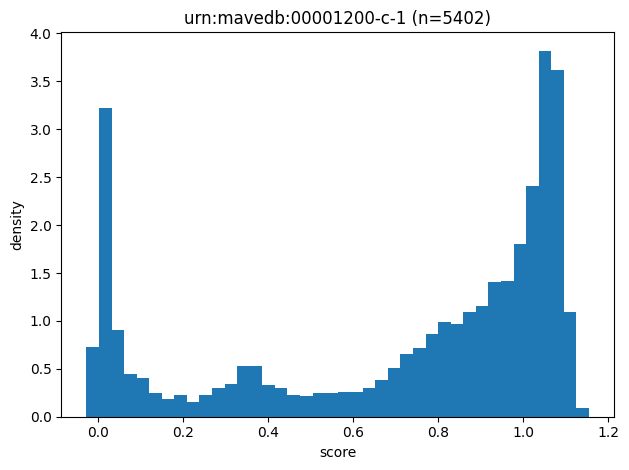

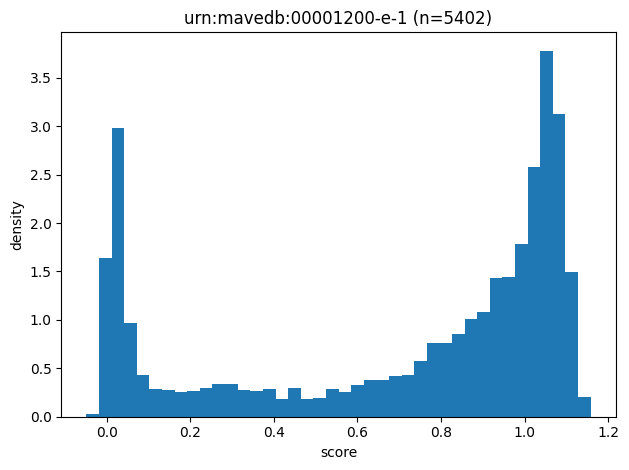

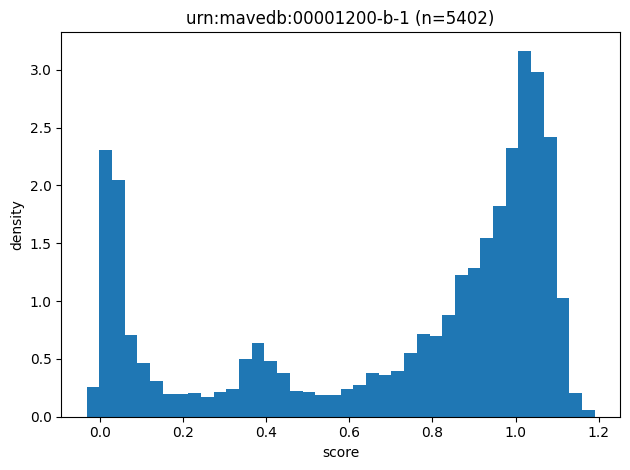

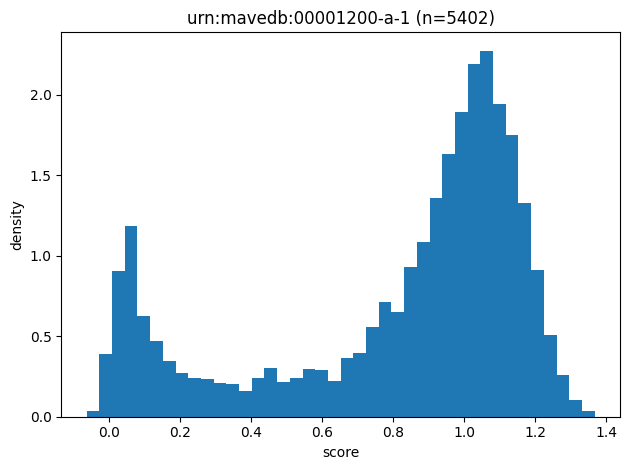

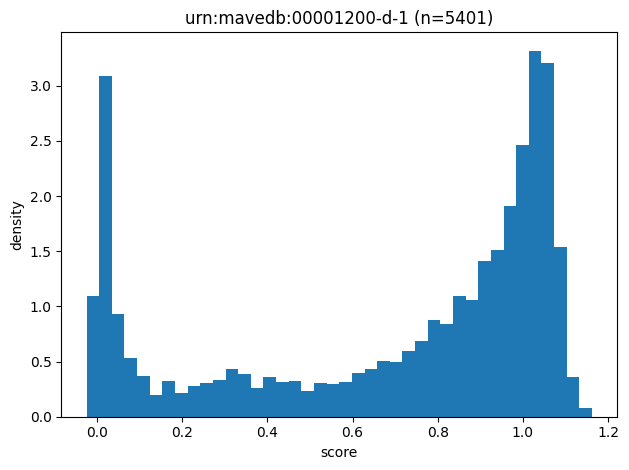

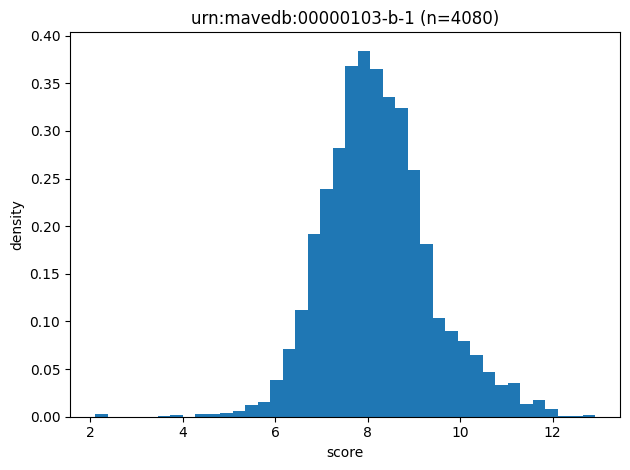

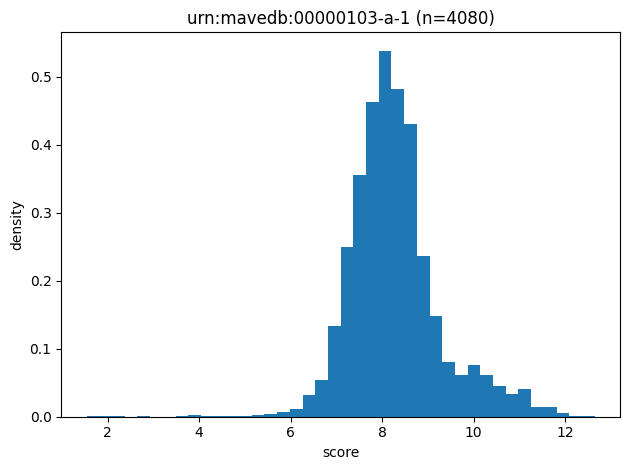

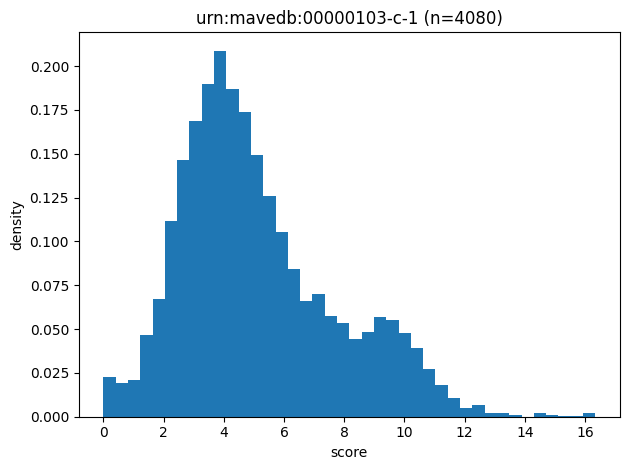

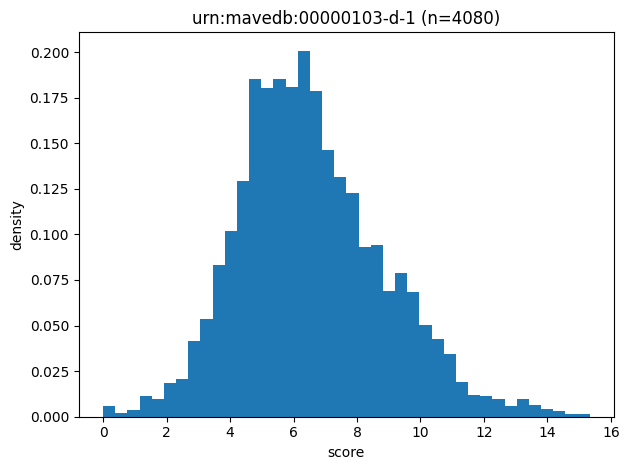

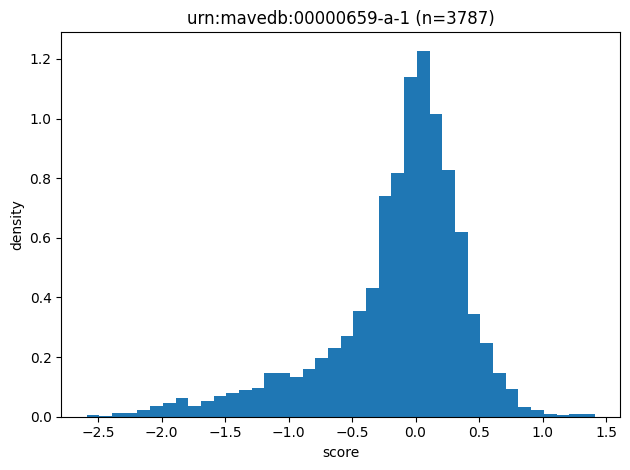

In [5]:
# Display scoresets seperately
for s in top_sets:
    x = raw_train_df.loc[raw_train_df["scoreset"]==s, "score"].dropna().values
    if len(x) < 5: 
        continue
    plt.figure()
    plt.hist(x, bins=40, density=True)
    plt.xlabel("score"); plt.ylabel("density")
    plt.title(f"{s} (n={len(x)})")
    plt.tight_layout()
    # Optional: save for deck
    # safe_name = str(s).replace(":", "_").replace("#","-")
    # plt.savefig(f"dist_{safe_name}.png", dpi=200)
    plt.show()
